In [66]:
import numpy as np
import jax.numpy as jnp
import jax.lax as jlx
import jax
from matplotlib import pyplot as plt
from jax.scipy.optimize import minimize

In [67]:
# initial parameters of the equation
R, L, C, A, PHI = 1/30, 1/15, 5, 2, 3
num_params = 1

def y_real(X):
    x = X[0]
    t1 = (19 / (51 * np.sqrt(47))) * np.sin(np.sqrt(47) * x / 4)
    t2 = 67 * np.cos(np.sqrt(47) * x / 4) / 51
    t3 = np.exp(x / 4)
    t4 = (4 / 51) * np.sin(3 * x)
    t5 = (16 / 51) * np.cos(3 * x)
    return ((t1 + t2) / t3) + t4 - t5

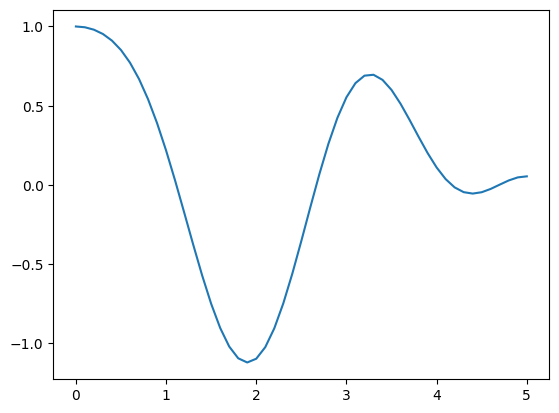

In [68]:
plt.plot([x for x in np.arange(0, 5.1, 0.1)], [y_real([x]) for x in np.arange(0, 5.1, 0.1)]); # plot the objective curve

In [69]:
# points for the constraining on initial conditions --> Dirichlet
passing_points_x = np.array([[0]])
passing_points_y = np.array([1])
passing_points_x, passing_points_y

(array([[0]]), array([1]))

In [70]:
# points for the constraining on initial conditions --> Neumann
passing_points_der_x = np.array([[0]], dtype="float64")
passing_points_der_y = np.array([0])
passing_points_der_x, passing_points_der_y

(array([[0.]]), array([0]))

In [71]:
# grid built on the domain, those are the points where the PINN will try to minimize the residual
grid = np.reshape(np.linspace(0, 5, 25), (-1, 1))
grid.shape, grid # points in the convex interval I = [0, 5]

((25, 1),
 array([[0.        ],
        [0.20833333],
        [0.41666667],
        [0.625     ],
        [0.83333333],
        [1.04166667],
        [1.25      ],
        [1.45833333],
        [1.66666667],
        [1.875     ],
        [2.08333333],
        [2.29166667],
        [2.5       ],
        [2.70833333],
        [2.91666667],
        [3.125     ],
        [3.33333333],
        [3.54166667],
        [3.75      ],
        [3.95833333],
        [4.16666667],
        [4.375     ],
        [4.58333333],
        [4.79166667],
        [5.        ]]))

In [72]:
# experimental datapoints which are known --> those are necessary because I am solving an Inverse Problem
data_x = np.reshape(np.arange(0, 5, 0.25), (-1, 1))
data_y = np.array([y_real(i) for i in data_x]) + np.random.normal(0, 0.1, (len(data_x), ))
data_x.shape, data_y.shape

((20, 1), (20,))

In [73]:
# initializing weights and biases for the whole neural networks
def initialize(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    n, m = layers_size[i + 1], layers_size[i]
    params.append(np.random.normal(0, np.sqrt(2 / (n + m)), (n, m))) # matrix --> Normal(0, sqrt(2/n+m))
    params.append(np.zeros((n, ))) # vectors --> 0
  for _ in range(num_params):
    params.append(np.random.normal(0, 1))
  return params

layers = [1, 12, 12, 12, 1]
params = initialize(layers) # simple FFNN --> more layers with less nodes --> typical in PINN
len(params)

9

In [74]:
# functions for computing the forward pass of the network --> 2 variations
def ANN_layer(data, params):
    W, b = params
    return jlx.map(lambda x: jnp.dot(W, x) + b, data)

ANN_layer_fast = jax.jit(ANN_layer)

def ANN(x, params):
  res = x
  for i in range(0, len(params) - 2, 2):
      if i >= 2: # ResNet architecture --> extra path for skipping connections in middle layers
          res += jnp.tanh(ANN_layer_fast(res, params[i:i + 2])) # tanh(z) as the activation function --> typical in PINN
      else:
          res = jnp.tanh(ANN_layer_fast(res, params[i:i + 2]))
  res = ANN_layer_fast(res, params[-2:])
  return res[:, 0]

ANN_fast = jax.jit(ANN)

def ANN_single_point(point, params): # same function, but for a single datapoint to forcast
    res = point
    for i in range(0, len(params) - 2, 2):
        if i >= 2: # ResNet architecture
            res += jnp.tanh(jnp.dot(params[i], res) + params[i + 1])
        else:
            res = jnp.tanh(jnp.dot(params[i], res) + params[i + 1])
    res = jnp.dot(params[-2], res) + params[-1]
    return res[0]

ANN_single_point_fast = jax.jit(ANN_single_point)
ANN_single_point_fast(grid[0], params[:-num_params])

Array(0., dtype=float32)

In [75]:
# helper function, used to compute the derivative of the network with respect of the inputs
def ANN_separate(x, params):
    return ANN_fast(x.reshape((-1, 1)), params)

grad_x = jax.jit(jax.jacrev(ANN_separate, argnums=0))

# all the specific functions for the derivative needed
def y_der_x(x, params):
    return jnp.diagonal(grad_x(x, params))
y_der_x_fast = jax.jit(y_der_x)

grad_x_x = jax.jit(jax.jacrev(y_der_x, argnums=0))

def y_der_x_x(x, params):
    return jnp.diagonal(grad_x_x(x, params))
y_der_x_x_fast = jax.jit(y_der_x_x)

In [76]:
# implementation of the loss function, unifying of all the subcomponents of the loss
def loss_points(params):
    pred_x = ANN_fast(passing_points_x, params)
    pred_der = y_der_x_fast(passing_points_der_x[:, 0], params)
    pred_data = ANN_fast(data_x, params)

    l1 = jnp.mean(jnp.square(passing_points_y - pred_x))
    l2 = jnp.mean(jnp.square(passing_points_der_y - pred_der))
    l3 = jnp.mean(jnp.square(data_y - pred_data))

    return l1 + l2 + l3

loss_points_fast = jax.jit(loss_points)

def loss_grid(params, pinn_params):
    k_pinn = pinn_params[0]
    x = grid[:, 0]
    y = ANN_fast(grid, params)
    y_der = y_der_x_fast(grid[:, 0], params)
    y_der_der = y_der_x_x_fast(grid[:, 0], params)
    return jnp.mean(jnp.square(y_der_der + (R / L) * y_der + k_pinn * y - A * jnp.cos(PHI * x)))

loss_grid_fast = jax.jit(loss_grid)

lam_1, lam_2 = 0.5, 1 # in this case the differential loss is more important --> I don't want to learn the noise in the data

def loss(params):
    return lam_1 * loss_points(params[:-num_params]) + lam_2 * loss_grid(params[:-num_params], params[-num_params:])

loss_fast = jax.jit(loss)
loss_grad = jax.jit(jax.grad(loss, argnums=0))
loss_fast(params)

Array(3.3839107, dtype=float32)

In [77]:
loss_grad(params);

In [78]:
# those 2 functions are needed to convert the parameters of the network from list of matrices to numpy array and viceversa
# those will be called a lot in the training cycle, in both ways, for working with the different shapes
# it's necessary because the forward pass uses the list of matrices form, while BFGS uses the numpy array version
def flat_list_into_numpy(params):
    arr = jnp.concatenate([p.reshape((-1, )) for p in params[:-num_params]])
    return jnp.concatenate([arr, jnp.array([params[i] for i in range(-num_params, 0, 1)])])

def unpack_params(params):
    params_list = list()
    idx, length = 0, 0
    for i in range(len(layers) - 1):
        length = layers[i] * layers[i + 1]
        params_list.append(params[idx: idx + length].reshape((layers[i + 1], layers[i])))
        idx += length

        length = layers[i + 1]
        params_list.append(params[idx: idx + length])
        idx += length
    for i in range(-num_params, 0, 1):
        params_list.append(params[i])
    return params_list

unpack_params_fast = jax.jit(unpack_params)
unpack_params_fast(flat_list_into_numpy(params));

In [79]:
def BFGS(w, dw, B_inv, lr_old):
    # search direction
    dir_v = -(B_inv @ dw)
    # line search
    lr = minimize(lambda x: loss_fast(unpack_params_fast(w + x[0] * dir_v)), jnp.array([0.1]), method="BFGS").x[0]
    if lr is None: # scipy may fail in finding the optimal search direction
        lr = lr_old
    lr_old = lr
    w_new = w + lr * dir_v # I use + sign because I inverted the sign of dir before
    dw_new = flat_list_into_numpy(loss_grad(unpack_params_fast(w_new)))
    # Sherman-Morrison update
    s = w_new - w
    y = dw_new - dw
    E = I - jnp.outer(y, s) / jnp.inner(y, s)
    B_inv = E.T @ B_inv @ E + jnp.outer(s, s) / jnp.inner(y, s)
    w = w_new
    dw = dw_new
    return w, dw, B_inv, lr_old

BFGS_fast = jax.jit(BFGS)

In [80]:
# BFGS optimization
w = flat_list_into_numpy(initialize(layers))

N = len(w)
max_epochs = 300
tol = 1e-6

dw = flat_list_into_numpy(loss_grad(unpack_params_fast(w)))
I = jnp.eye(N)
B_inv = I.copy()
history_train = list()
history_k = list()

lr_old = 0.1

epoch = 0
while epoch < max_epochs and np.linalg.norm(dw) > tol:
    history_k.append(w[-1])
    w, dw, B_inv, lr_old = BFGS_fast(w, dw, B_inv, lr_old)
    if epoch % 10 == 0:
        l = loss_fast(unpack_params_fast(w))
        history_train.append(l)
        print(f"epoch {epoch}")
        print(f"loss: {l}")
        print(f"gradient norm: {np.linalg.norm(dw)}\n")
    epoch += 1

print(f"\n\nLoss of the final iteration : {loss_fast(unpack_params_fast(w))}\n")

epoch 0
loss: 2.726933479309082
gradient norm: 2.7164974212646484

epoch 10
loss: 1.5333706140518188
gradient norm: 1.4813963174819946

epoch 20
loss: 0.9204464554786682
gradient norm: 1.6428134441375732

epoch 30
loss: 0.43785256147384644
gradient norm: 1.929060459136963

epoch 40
loss: 0.29110878705978394
gradient norm: 2.610450506210327

epoch 50
loss: 0.14448903501033783
gradient norm: 1.0892579555511475

epoch 60
loss: 0.10077992081642151
gradient norm: 0.5464351773262024

epoch 70
loss: 0.06597378849983215
gradient norm: 1.1905198097229004

epoch 80
loss: 0.026969511061906815
gradient norm: 1.0109145641326904

epoch 90
loss: 0.007007726468145847
gradient norm: 0.3992540240287781

epoch 100
loss: 0.0035235818941146135
gradient norm: 0.12937617301940918

epoch 110
loss: 0.00339106866158545
gradient norm: 0.012317648157477379

epoch 120
loss: 0.003307485952973366
gradient norm: 0.011294920928776264

epoch 130
loss: 0.0032488354481756687
gradient norm: 0.013890402391552925

epoch 140

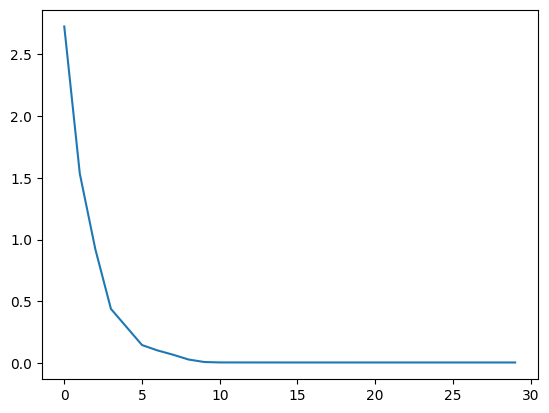

In [81]:
plt.plot(history_train);

In [82]:
params = unpack_params_fast(w)

# Plots for showing the results

In [83]:
c = 1 / (L * params[-1]) # this operation is needed to extract the Capacity from the learned parameter

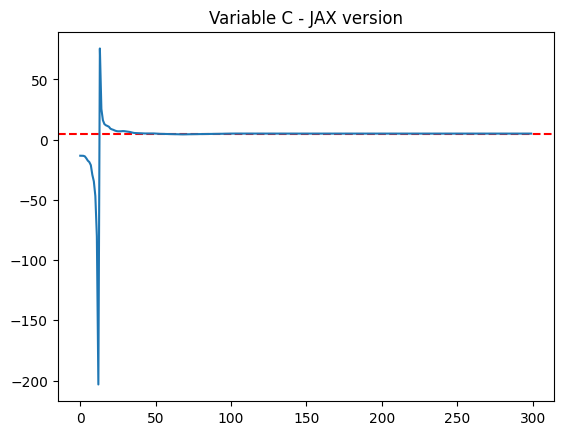

In [84]:
plt.title("Variable C - JAX version")
plt.axhline(y=C, c="r", linestyle="dashed")
plt.plot(1 / (L * np.array(history_k))); # history on the parameter C, strongly non-monotonic. Very different from DeepXDE

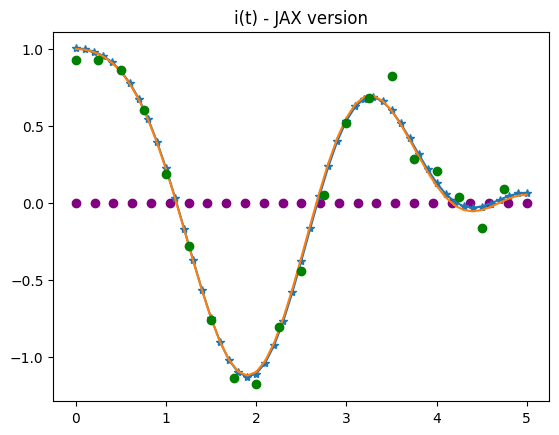

In [85]:
plt.title("i(t) - JAX version")
plt.plot([x for x in np.arange(0, 5.1, 0.1)], [ANN_single_point_fast(np.array([x]), params[:-num_params]) for x in np.arange(0, 5.1, 0.1)], marker="*", zorder=0)
plt.plot([x for x in np.arange(0, 5.1, 0.1)], [y_real([x]) for x in np.arange(0, 5.1, 0.1)], zorder=1)
plt.scatter([x for x in np.linspace(0, 5, 25)], [0 for x in np.linspace(0, 5, 25)], marker="o", c="purple", zorder=-2)
plt.scatter([x[0] for x in data_x], [x for x in data_y], c="g", zorder=3);

In [86]:
print(f"Capacity real = {C}, capacity from the PINN = {np.round(np.float64(c), 2)}")

Capacity real = 5, capacity from the PINN = 5.06
